In [3]:
import sys
sys.path.append("../src")
import preprocessing
import cconfig
import clustering

# Plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt

# Load data and preprocess

In [4]:
# select type of features and default values
selected_features=cconfig.SELECTED_FEATURES_FLOW
dataset_type=cconfig.DATASET_TYPE_BIFLOW
max_num_clusters=cconfig.DEFAULT_NUM_CLUSTERS
sort_anomalies=cconfig.BIFLOW_ANOMALIES_SORT

# Bidirectional flow

In [ ]:
# load original data in dataframes, sample, select some features and scale
df,df_Normal,df_Attack=preprocessing.data_load(0.01,None,False,dataset_type)
print(df.columns)
X=preprocessing.data_scale(df[selected_features])
X_Normal=preprocessing.data_scale(df_Normal[selected_features])
X_Attack=preprocessing.data_scale(df_Attack[selected_features])

# KMEANS

In [ ]:
# find the best number of clusters
df_silhouette = clustering.kmeans_get_number_clusters(X_Normal)

# select best number of clusters for kmeans
max_num_clusters=df_silhouette.iloc[df_silhouette.score.idxmax() ]['Num Clusters']

# plot the result for reference
df_silhouette.plot(x='Num Clusters', y='score')

Variability explained by the PC: 0.29072658834907605

Exporting FLOW_KMEANS...
Number of clusters: 2

Cluster 0: 23417 data points

Cluster 1: 416706 data points

DONE.
-------------------------------------------------------


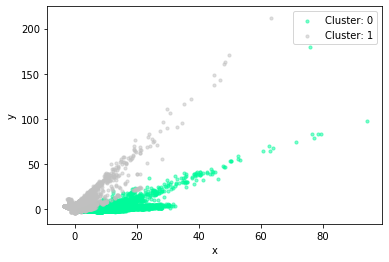

In [16]:
# fit kmeans model with normal day data
kmeans=clustering.kmeans_train(X_Normal,int(max_num_clusters))

# predictions with attack dataset
labels=clustering.kmeans_predict(X_Attack,kmeans)

# dimensionality reduction
XR=preprocessing.get_pc(X_Attack,2)

# print results
clustering.clustering_print_results(df_Attack,labels,selected_features,XR,True,True,dataset_type+'_kmeans')

In [17]:
# print anomalies
index_anomalies=clustering.kmeans_anomalies(X_Attack,kmeans)
df_anomalies=df_Attack.iloc[index_anomalies,:]
df_anomalies.sort_values(by=sort_anomalies,ascending=False)

,src_ip,dst_ip,src_port,dst_port,fwd_packets,bwd_packets,fwd_bytes,bwd_bytes,fwd_duration,flow_start,...,count_src,count_serv_src,count_serv_dst,count_dest_conn,count_src_conn,count_serv_src_conn,count_count_serv_src_conn,cluster,x,y
430,192.168.10.8,104.24.25.85,5741,80,30,57,0,81760,0.104827,2017-07-07 17:00:14.623,...,0,2,0,4,0,2,0,1,1.104619,4.211180
439985,192.168.10.14,192.168.10.3,59150,88,1,2,314,3064,0.000000,2017-07-07 20:01:07.658,...,4,3,0,23,8,3,0,0,6.715274,2.799858
433211,192.168.10.12,192.168.10.3,46914,88,2,2,3110,3108,0.000003,2017-07-07 19:44:03.738,...,2,3,0,17,11,9,0,0,11.318990,0.574315
426513,192.168.10.50,192.168.10.3,58572,88,2,1,3174,1590,0.000003,2017-07-07 19:25:36.717,...,1,2,0,13,9,40,0,0,10.360966,0.359243
934,192.168.10.50,192.168.10.16,139,48318,35,74,140,0,10801.397241,2017-07-07 17:01:33.674,...,13,0,0,8,34,0,0,0,79.537496,82.821842


# DBSCAN

In [ ]:
# define hyper parameters for dbscan
eps=0.5
min_samples=26

# fit and predict
dblabels=clustering.dbscan_fit_predict(eps,min_samples,X)

# do dimensionality reduction to plot
XR=preprocessing.get_pc(X,2)

# print and plot
clustering.clustering_print_results(df,dblabels,selected_features,XR,True,True,dataset_type+'_dbscan')

# OPTIC

In [ ]:
# define hyper params for optics
eps=1.5
min_samples=20

# predict using optics
labels=clustering.optics_fit_predict(X,min_samples,'dbscan', eps)

# do dimensionality reduction to plot
XR=preprocessing.get_pc(X,2)

# print and plot
clustering.clustering_print_results(df,labels,selected_features,XR,True,True,dataset_type+'_optic')

In [ ]:
df_anomalies=clustering.optics_anomalies(df,labels)
df_anomalies.sort_values(by=sort_anomalies,ascending=False)

# IFOREST

In [ ]:
# model iforest
iforest=clustering.iforest_train(X_Normal)
labels=clustering.iforest_predict(X_Attack,iforest)

# dimensionality reduction
XR=preprocessing.get_pc(X_Attack,2)

# print results
clustering.clustering_print_results(df_Attack,labels,selected_features,XR,True,True,dataset_type+'_iforest')

In [ ]:
# get anomalies
df_anomalies=clustering.iforest_anomalies(df_Attack,labels)
df_anomalies.sort_values(by=sort_anomalies,ascending=False)

# LOF

In [ ]:
outliers_fraction=0.05
n_neighbors=30
labels=clustering.lof_fit_predict(X,outliers_fraction,n_neighbors)

# dimensionality reduction
XR=preprocessing.get_pc(X,2)

# print results
clustering.clustering_print_results(df,labels,cconfig.SELECTED_FEATURES_FLOW,XR,True,True,dataset_type+'_lof')

In [ ]:
# get anomalies
df_anomalies=clustering.lof_anomalies(df,labels)
df_anomalies.sort_values(by=sort_anomalies,ascending=False)

# OCSVM

In [ ]:
# train and test the model
outliers_fraction=0.05
labels=clustering.ocsvm_fit_predict(X_Normal,X_Attack,outliers_fraction)

# dimensionality reduction
XR=preprocessing.get_pc(X_Attack,3)

# print results
clustering.clustering_print_results(df_Attack,labels,cconfig.SELECTED_FEATURES_FLOW,XR,True,True,dataset_type+'_ocsvm')

In [ ]:
# get anomalies
df_anomalies=clustering.ocsvm_anomalies(df_Attack,labels)
df_anomalies.sort_values(by=sort_anomalies,ascending=False)